In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
import skimage.filters as skf
import sys
import warnings
from scipy import ndimage as scnd
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import math
import sys
import numba
from skimage.transform import rescale as skitres
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

In [2]:
warnings.filterwarnings('ignore')
sys.path.append('/home/cades/Codes/stemtools')
import stemtools as st
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import numexpr as ne
from scipy import optimize as sio

def get_flat_dpc(data4D_flat,centered=True):
    if centered:
        beam_x = data4D_flat.shape[1]
        beam_y = data4D_flat.shape[0]
    else:
        CentralDisk = np.median(data4D_flat,axis=0)
        beam_x,beam_y,_ = st.util.sobel_circle(CentralDisk)
    yy, xx = np.mgrid[0:data4D_flat.shape[1],0:data4D_flat.shape[2]]
    FlatSum = np.sum(data4D_flat,axis=(-1,-2))
    FlatY = np.multiply(data4D_flat,yy)
    FlatX = np.multiply(data4D_flat,xx)
    YCom = (np.sum(FlatY,axis=(-1,-2))/FlatSum) - beam_x
    XCom = (np.sum(FlatX,axis=(-1,-2))/FlatSum) - beam_y
    return XCom,YCom

def cart2pol(x, y):
    rho = ne.evaluate("((x**2) + (y**2)) ** 0.5")
    phi = ne.evaluate("arctan2(y, x)")
    return (rho, phi)

def pol2cart(rho, phi):
    x = ne.evaluate("rho * cos(phi)")
    y = ne.evaluate("rho * sin(phi)")
    return (x, y)

def angle_fun(angle,rho_dpc,phi_dpc):
    x_dpc,y_dpc = pol2cart(rho_dpc,(phi_dpc + (angle*((np.pi)/180))))
    charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    angle_sum = np.sum(np.abs(charge))
    return angle_sum

def optimize_angle(x_dpc,y_dpc,adf_stem):
    flips = np.zeros(4,dtype=bool)
    flips[2:4] = True
    chg_sums = np.zeros(4,dtype=x_dpc.dtype)
    angles = np.zeros(4,dtype=x_dpc.dtype)
    x0 = 90
    for ii in range(2):
        to_flip = flips[2*ii]
        if to_flip:
            xdpcf = np.flip(x_dpc)
        else:
            xdpcf = x_dpc
        rho_dpc,phi_dpc = cart2pol(xdpcf,y_dpc)
        x = sio.minimize(angle_fun,x0,args=(rho_dpc,phi_dpc))
        min_x = x.x
        sol1 = min_x - 90
        sol2 = min_x + 90
        chg_sums[int(2*ii)] = np.sum(charge_dpc(xdpcf,y_dpc,sol1)*adf_stem)
        chg_sums[int(2*ii+1)] = np.sum(charge_dpc(xdpcf,y_dpc,sol2)*adf_stem)
        angles[int(2*ii)] = sol1
        angles[int(2*ii+1)] = sol2
    angle = angles[chg_sums==np.amin(chg_sums)][0]
    final_flip = flips[chg_sums==np.amin(chg_sums)][0]
    return angle, final_flip

def corrected_dpc(x_dpc,y_dpc,angle,flipper):
    if flipper:
        xdpcf = np.fliplr(x_dpc)
    else:
        xdpcf = np.copy(x_dpc)
    rho_dpc,phi_dpc = cart2pol(xdpcf,y_dpc)
    x_dpc2,y_dpc2 = pol2cart(rho_dpc,(phi_dpc + (angle*((np.pi)/180))))
    return x_dpc2,y_dpc2

def potential_dpc(x_dpc,y_dpc,angle=0):
    if angle==0:
        potential = integrate_dpc(x_dpc,y_dpc)
    else:
        rho_dpc,phi_dpc = cart2pol(x_dpc,y_dpc)
        x_dpc,y_dpc = pol2cart(rho_dpc,phi_dpc + (angle*((np.pi)/180)))
        potential = integrate_dpc(x_dpc,y_dpc)
    return potential

def charge_dpc(x_dpc,y_dpc,angle=0):
    if angle==0:
        charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    else:
        rho_dpc,phi_dpc = cart2pol(x_dpc,y_dpc)
        x_dpc,y_dpc = pol2cart(rho_dpc,phi_dpc + (angle*((np.pi)/180)))
        charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    return charge

def integrate_dpc(xshift,
                  yshift,
                  fourier_calibration=1):
    #Initialize matrices
    size_array = np.asarray(np.shape(xshift))
    x_mirrored = np.zeros(2*size_array,dtype=np.float64)
    y_mirrored = np.zeros(2*size_array,dtype=np.float64)
    
    #Generate antisymmetric X arrays
    x_mirrored[0:size_array[0],0:size_array[1]] = np.fliplr(np.flipud(0 - xshift))
    x_mirrored[0:size_array[0],size_array[1]:(2*size_array[1])] = np.fliplr(0 - xshift)
    x_mirrored[size_array[0]:(2*size_array[0]),0:size_array[1]] = np.flipud(xshift)
    x_mirrored[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])] = xshift
    
    #Generate antisymmetric Y arrays
    y_mirrored[0:size_array[0],0:size_array[1]] = np.fliplr(np.flipud(0 - yshift))
    y_mirrored[0:size_array[0],size_array[1]:(2*size_array[1])] = np.fliplr(yshift)
    y_mirrored[size_array[0]:(2*size_array[0]),0:size_array[1]] = np.flipud(0 - yshift)
    y_mirrored[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])] = yshift
    
    #Calculated Fourier transform of antisymmetric matrices
    x_mirr_ft = np.fft.fft2(x_mirrored)
    y_mirr_ft = np.fft.fft2(y_mirrored)
    
    #Calculated inverse Fourier space calibration
    qx = np.mean(np.diff((np.arange(-size_array[1],size_array[1], 1))/
                         (2*fourier_calibration*size_array[1])))
    qy = np.mean(np.diff((np.arange(-size_array[0],size_array[0], 1))/
                         (2*fourier_calibration*size_array[0])))
    
    #Calculate mirrored CPM integrand
    mirr_ft = (x_mirr_ft + ((1j)*y_mirr_ft))/(qx + ((1j)*qy))
    mirr_int = np.fft.ifft2(mirr_ft)
    
    #Select integrand from antisymmetric matrix
    integrand = np.abs(mirr_int[size_array[0]:(2*size_array[0]),size_array[1]:(2*size_array[1])])
    
    return integrand

def centerCBED(data4D_flat,
               x_cen,
               y_cen):
    image_size = np.asarray(data4D_flat.shape[1:3])
    fourier_cal_y = (np.linspace((-image_size[0]/2), ((image_size[0]/2) - 1), image_size[0]))/image_size[0]
    fourier_cal_x = (np.linspace((-image_size[1]/2), ((image_size[1]/2) - 1), image_size[1]))/image_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(image_size/2) - np.asarray((x_cen,y_cen))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    FFT_4D = np.fft.fftshift(np.fft.fft2(data4D_flat,axes=(-1,-2)),axes=(-1,-2))
    moved_in_fourier = np.abs(np.fft.ifft2(np.multiply(FFT_4D,move_phase),axes=(-1,-2)))
    return moved_in_fourier

def wavelength_pm(voltage_kV):
    m = 9.109383 * (10 ** (-31))  # mass of an electron
    e = 1.602177 * (10 ** (-19))  # charge of an electron
    c = 299792458  # speed of light
    h = 6.62607 * (10 ** (-34))  # Planck's constant
    voltage = voltage_kV * 1000
    numerator = (h ** 2) * (c ** 2)
    denominator = (e * voltage) * ((2*m*(c ** 2)) + (e * voltage))
    wavelength_pm = (10 ** 12) *((numerator/denominator) ** 0.5) #in picometers
    return wavelength_pm

def get_sampling(datashape,aperture_mrad,voltage,calibration_pm,radius_pixels):
    yscanf = (np.linspace((-datashape[0]/2), 
                          ((datashape[0]/2) - 1), datashape[0]))/(calibration_pm*datashape[0])
    xscanf = (np.linspace((-datashape[1]/2), 
                          ((datashape[1]/2) - 1), datashape[1]))/(calibration_pm*datashape[1])
    [xscanf_m, yscanf_m] = np.meshgrid(xscanf, yscanf)
    scanf_m = 1000*wavelength_pm(voltage)*(((xscanf_m**2) + (yscanf_m)**2)**0.5)
    fourier_beam = np.zeros_like(scanf_m)
    fourier_beam[scanf_m < aperture_mrad] = 1
    real_rad = (np.sum(fourier_beam)/np.pi)**0.5
    sampling = radius_pixels/real_rad
    return sampling

In [4]:
loaded_data = np.load('/home/cades/ptychotest.npz',allow_pickle=True)
loaded_data.files

['Data_4D', 'DataADF', 'info_4D', 'infoADF']

In [5]:
st.tic()
Data_4D = loaded_data[loaded_data.files[0]]
DataADF = loaded_data[loaded_data.files[1]]
info_4D = np.ndarray.tolist(loaded_data[loaded_data.files[2]])
infoADF = np.ndarray.tolist(loaded_data[loaded_data.files[3]])
st.toc()

Elapsed time: 39.385913 seconds.



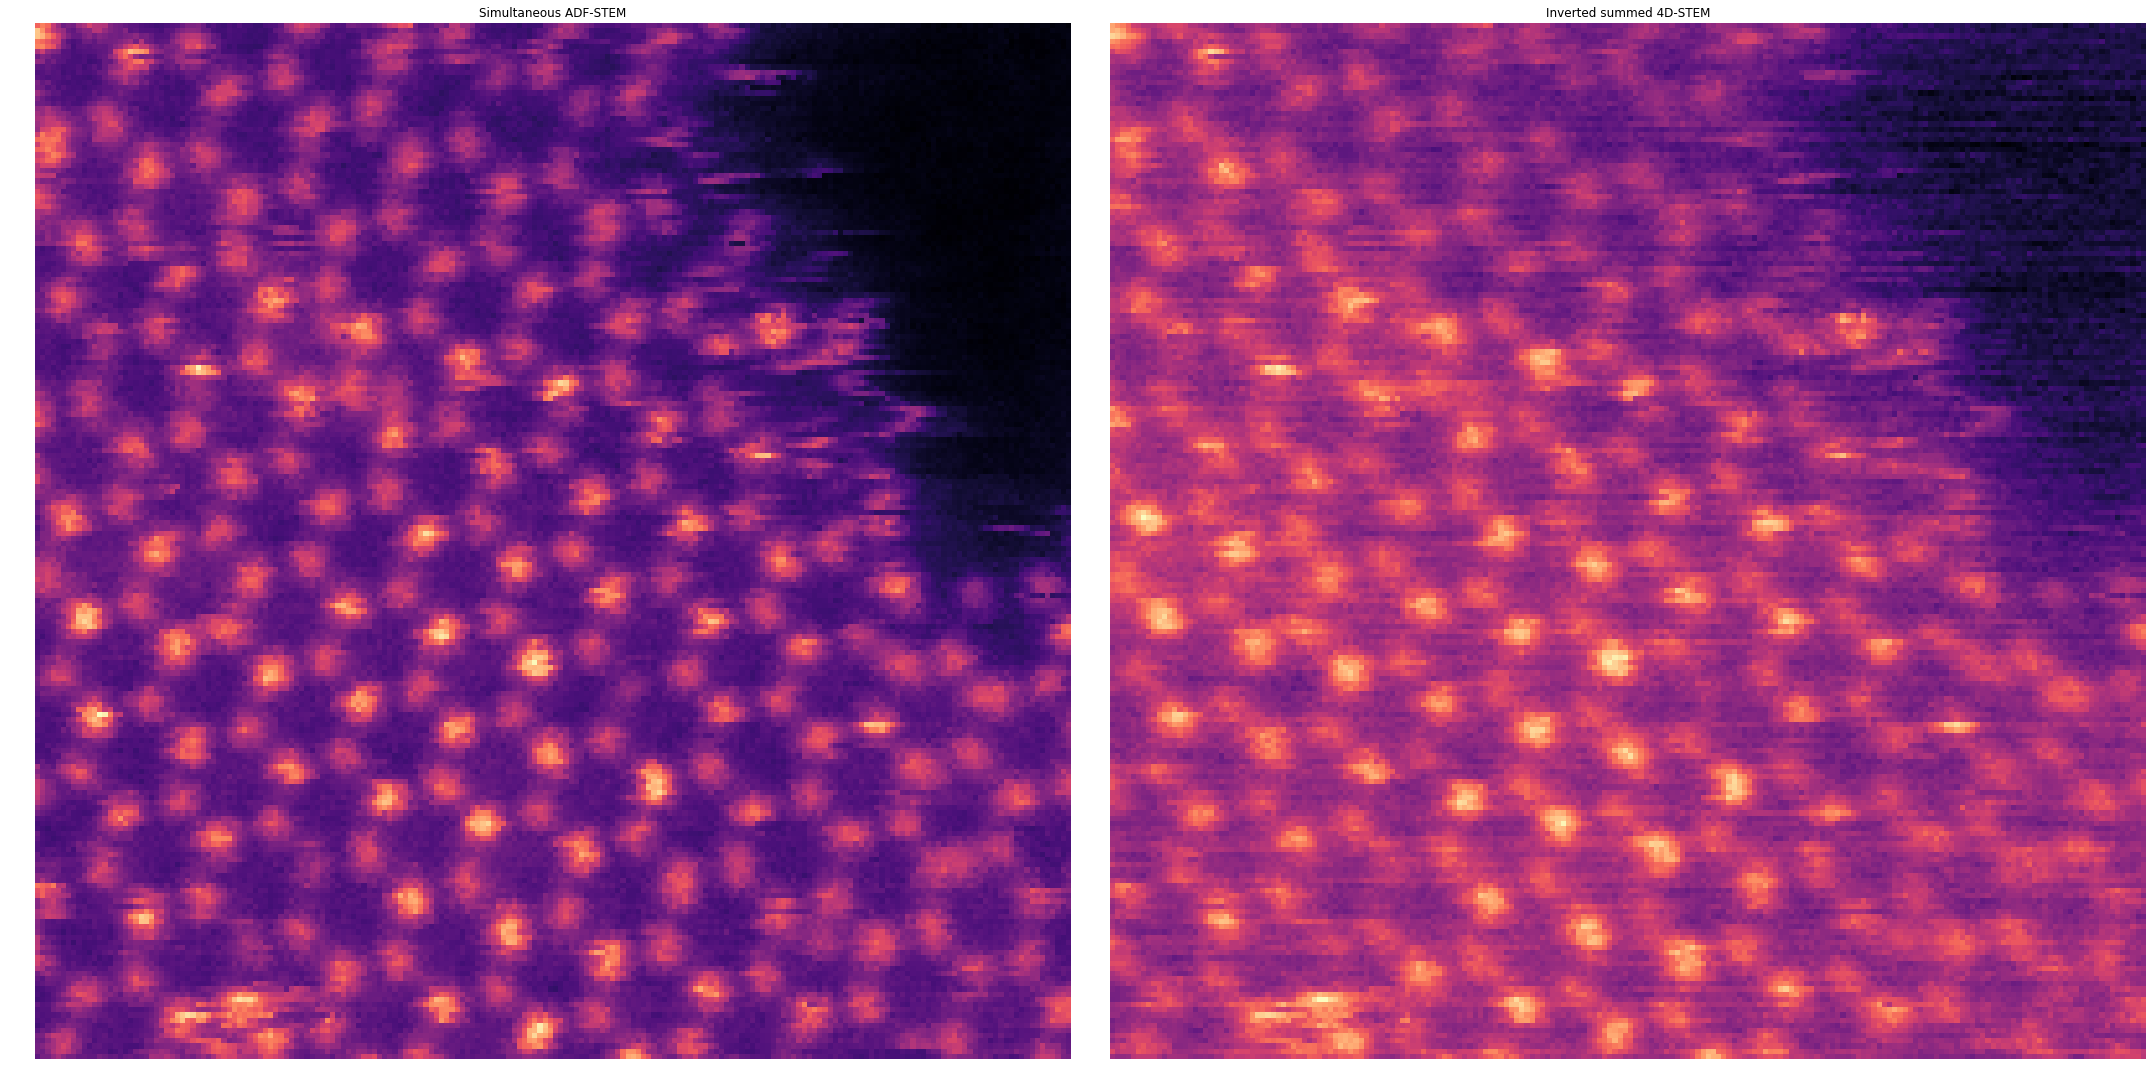

In [6]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(DataADF)
plt.axis('off')
plt.title('Simultaneous ADF-STEM')
plt.subplot(1,2,2)
plt.imshow(-np.sum(Data_4D,axis=(-1,-2)))
plt.axis('off')
plt.title('Inverted summed 4D-STEM')
plt.tight_layout()

In [7]:
Flat4D = np.reshape(Data_4D,(Data_4D.shape[0]*Data_4D.shape[1],Data_4D.shape[2],Data_4D.shape[3]))
CentralDisk = np.median(Flat4D,axis=0)

Text(0.5, 1.0, 'Diffraction Disk')

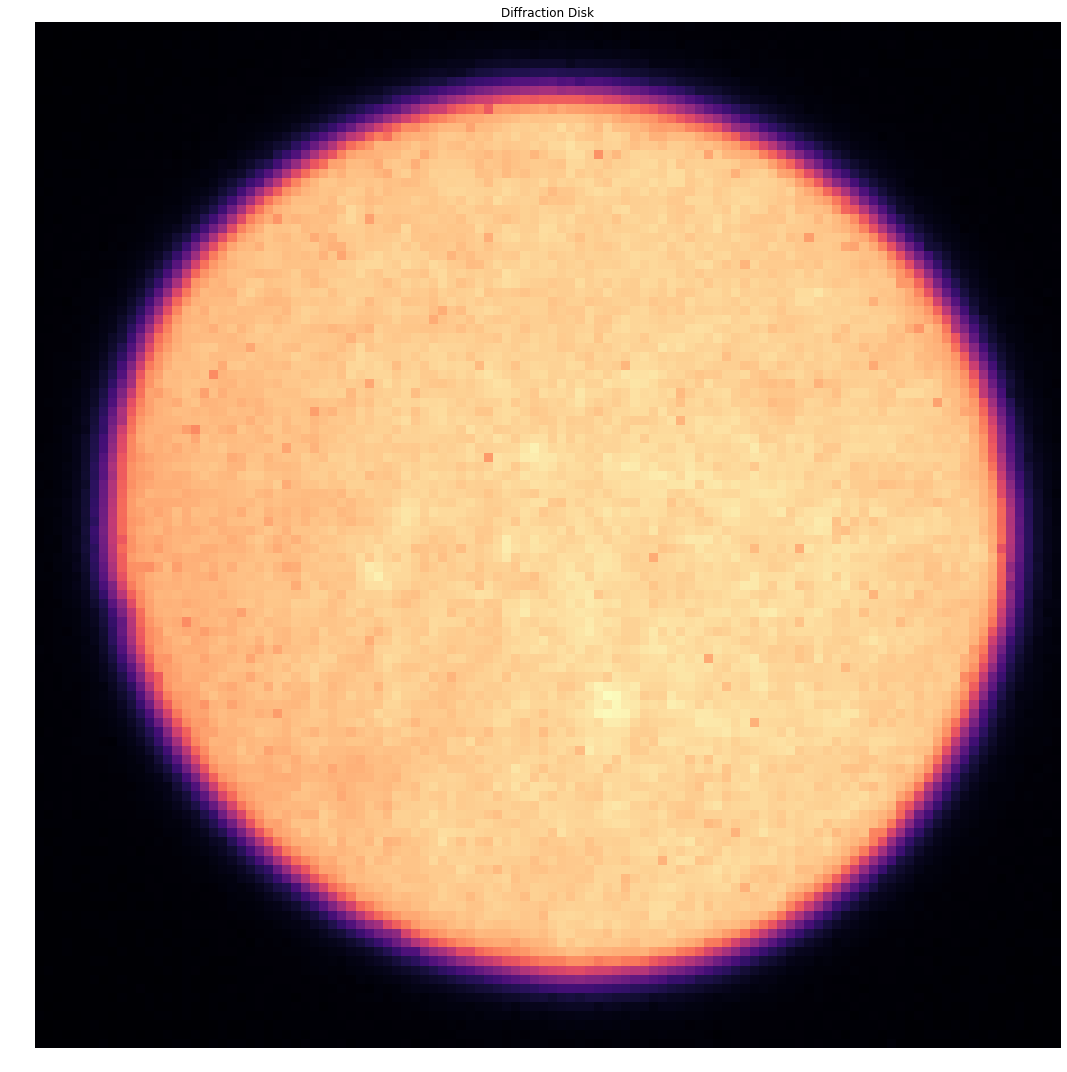

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(CentralDisk)
plt.axis('off')
plt.title('Diffraction Disk')

In [9]:
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)

In [10]:
beam_x,beam_y,beam_r

(57.36367223535996, 54.99601216697518, 48.712829479798)

In [11]:
st.tic()
Flat4D = centerCBED(Flat4D,beam_x,beam_y)
CentralDisk = np.median(Flat4D,axis=0)
beam_x,beam_y,beam_r = st.util.sobel_circle(CentralDisk)
st.toc()

Elapsed time: 161.047760 seconds.



In [12]:
beam_x,beam_y,beam_r

(56.16114677992617, 55.940141278394044, 48.7043949583004)

In [13]:
st.tic()
dpc_x,dpc_y = get_flat_dpc(Flat4D)
dpc_x = np.reshape(dpc_x,(Data_4D.shape[0],Data_4D.shape[1]))
dpc_y = np.reshape(dpc_y,(Data_4D.shape[0],Data_4D.shape[1]))
st.toc()

Elapsed time: 13.546190 seconds.



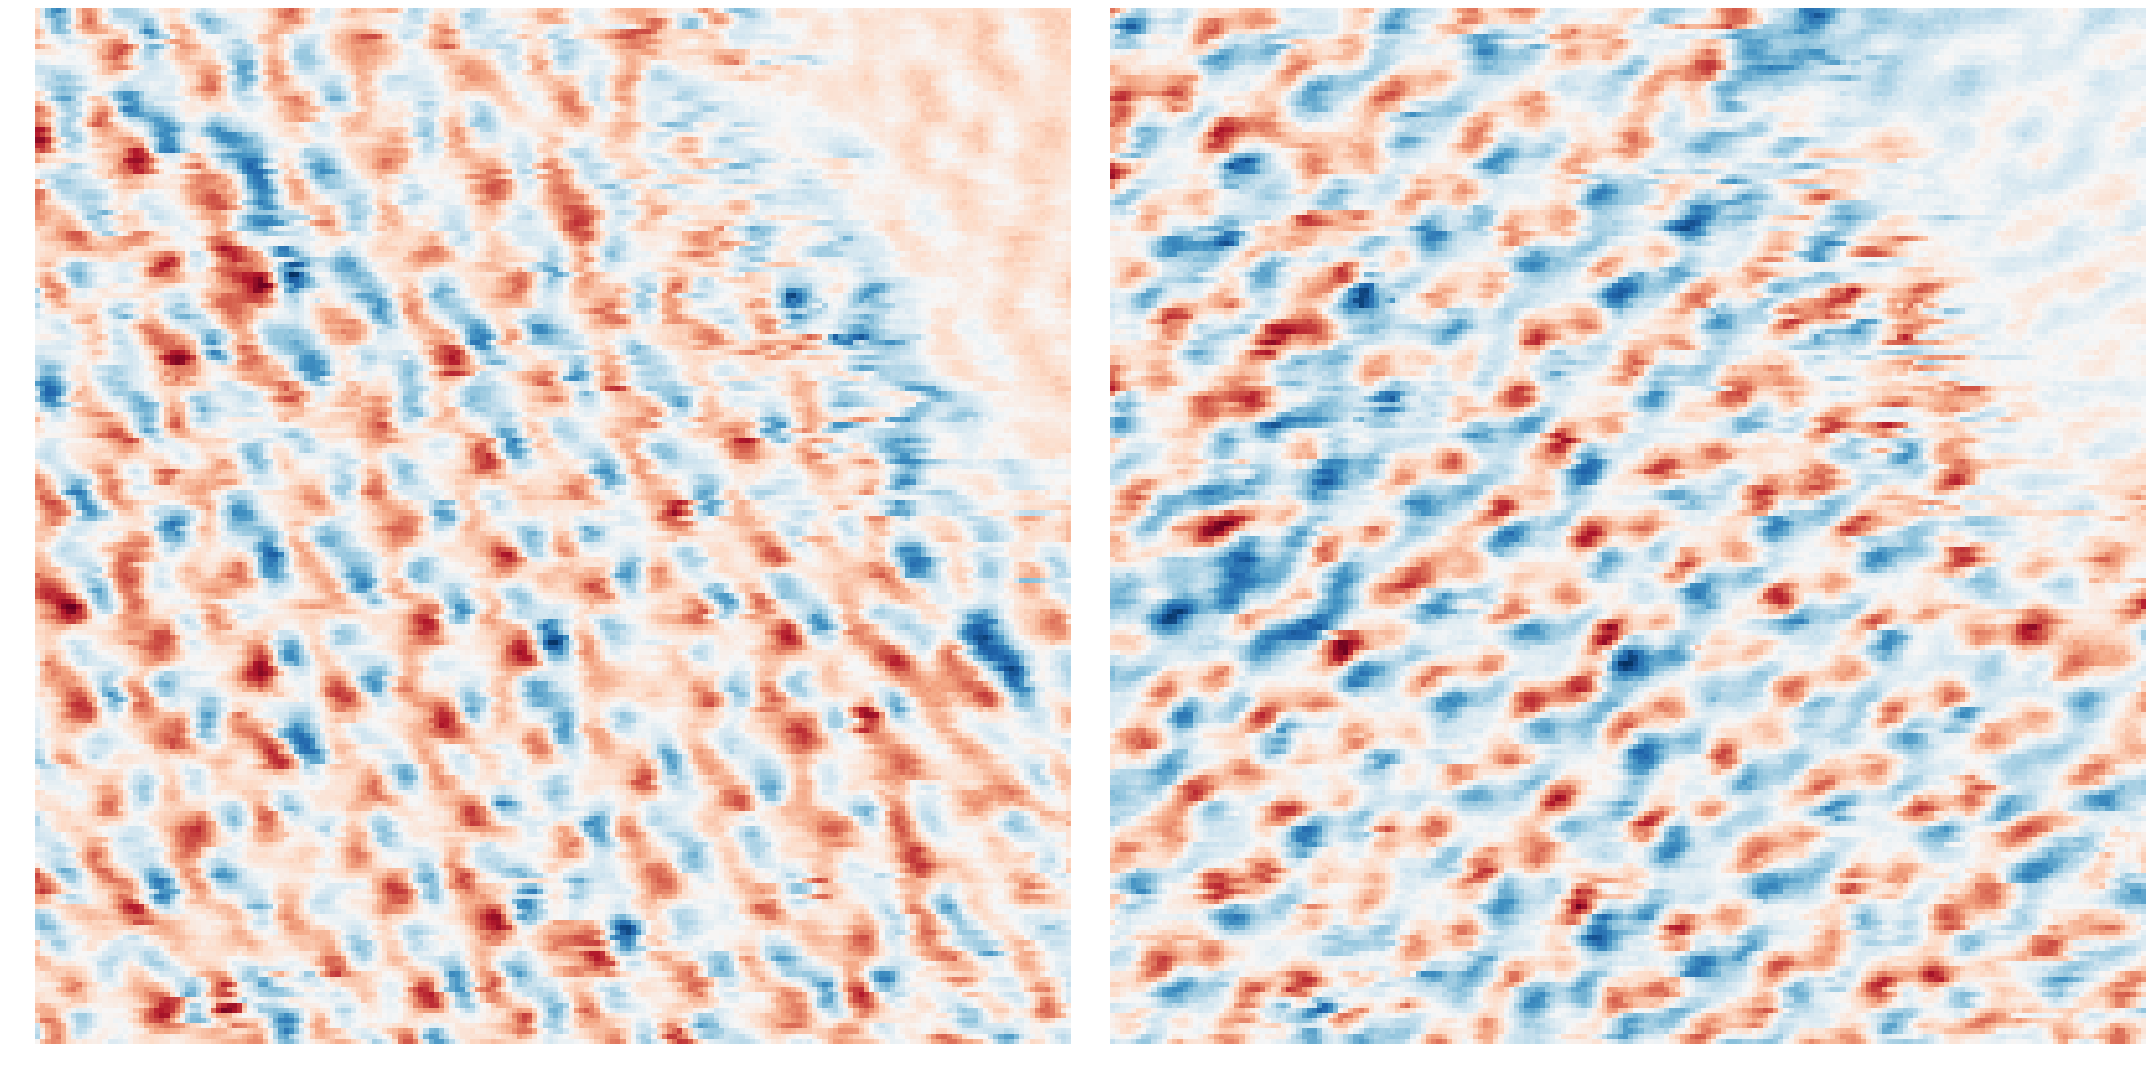

In [14]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_x,cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dpc_y,cmap='RdBu_r')
plt.axis('off')
plt.tight_layout()

In [15]:
st.tic()
rotangle,flipval = optimize_angle(dpc_x,dpc_y,DataADF)
dpc_xC,dpc_yC = corrected_dpc(dpc_x,dpc_y,rotangle,flipval)
st.toc()

Elapsed time: 3.600432 seconds.



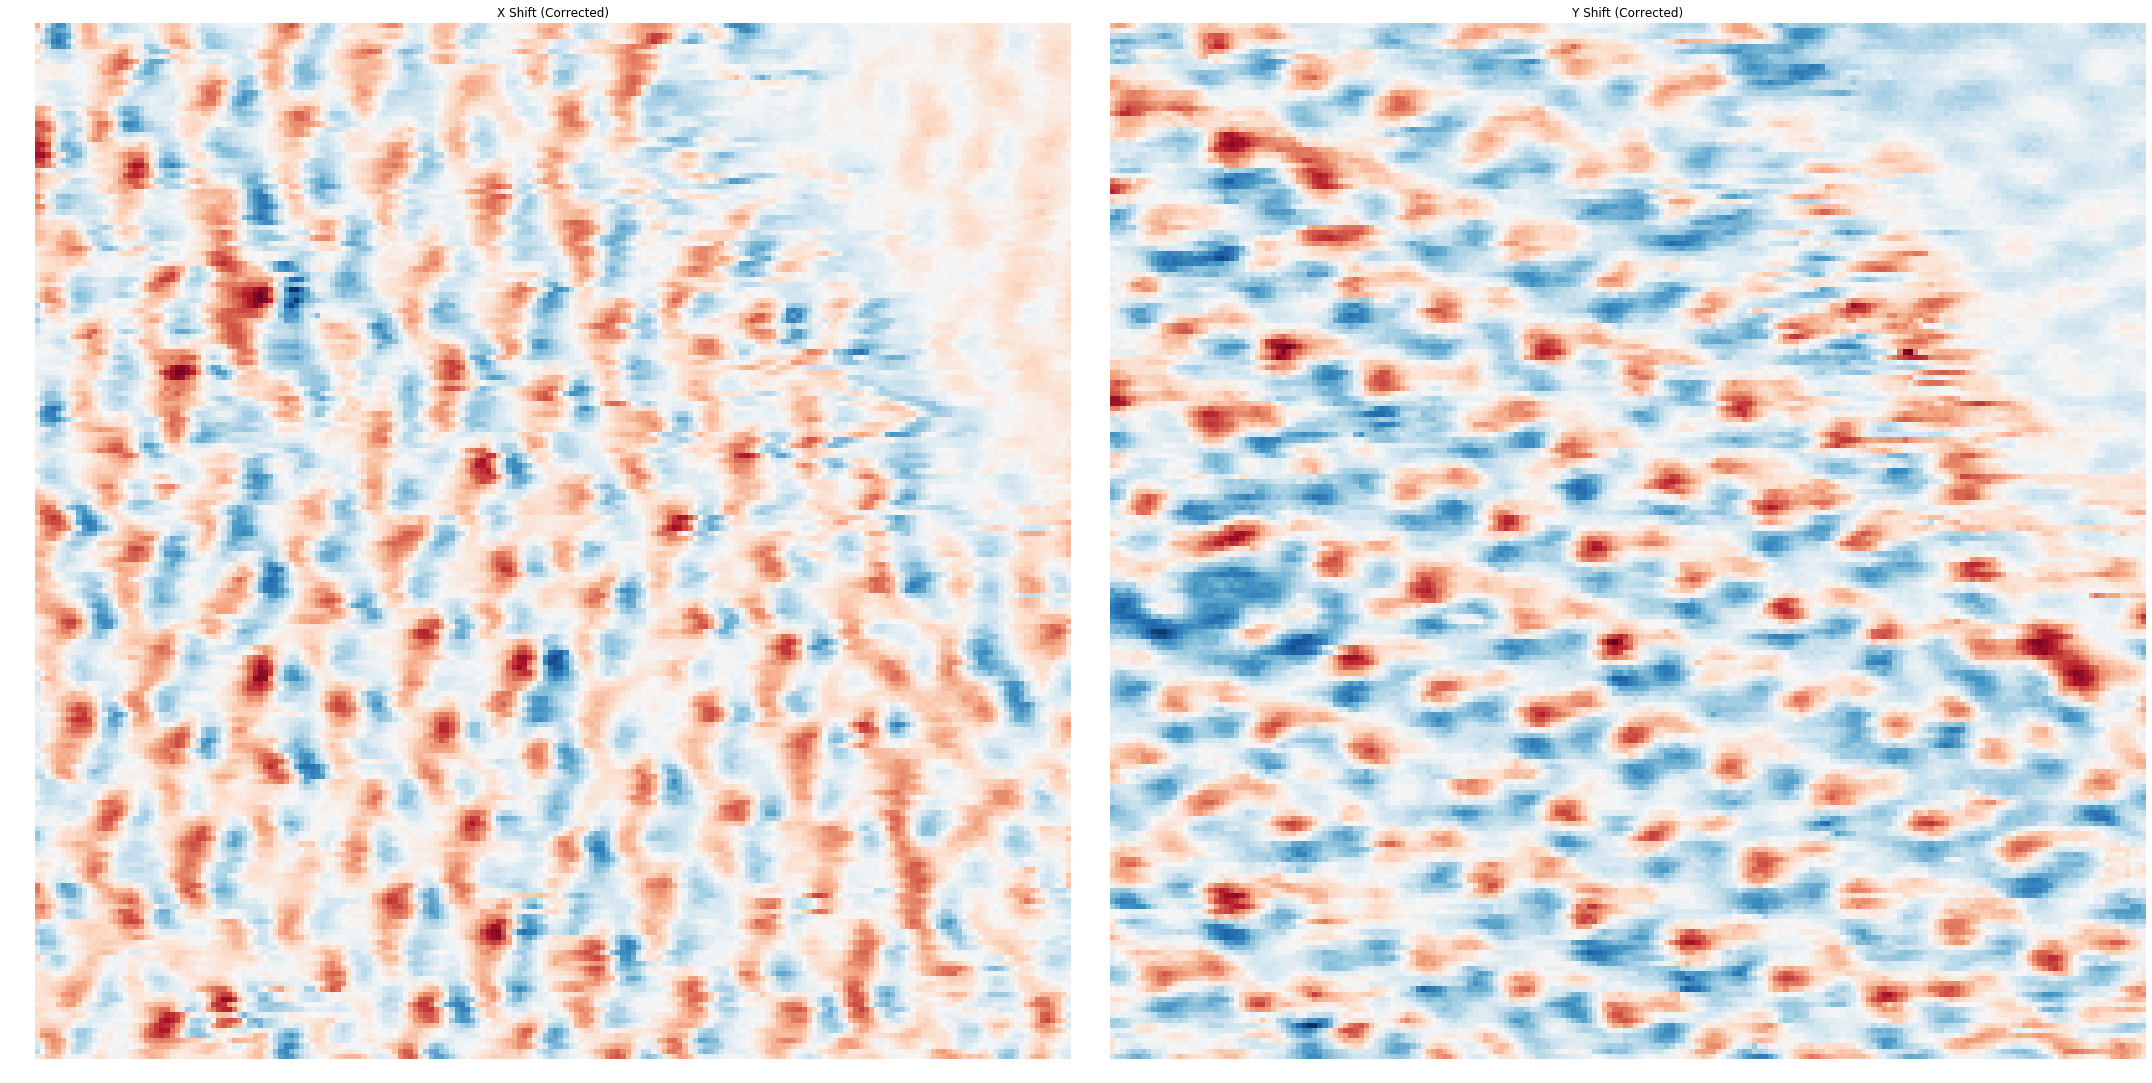

In [16]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(dpc_xC,cmap='RdBu_r')
plt.axis('off')
plt.title('X Shift (Corrected)')
plt.subplot(1,2,2)
plt.imshow(dpc_yC,cmap='RdBu_r')
plt.axis('off')
plt.title('Y Shift (Corrected)')
plt.tight_layout()

In [17]:
@numba.jit
def resizer1D(data,N):   
    M = data.size
    res = np.zeros(N,dtype=data.dtype)
    carry=0
    m=0
    for n in range(int(N)):
        data_sum = carry
        while m*N - n*M < M :
            data_sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        data_sum -= carry
        res[n] = data_sum*N/M
    return res

@numba.jit
def resizer1D_numbaopt(data,res,N):   
    M = data.size
    carry=0
    m=0
    for n in range(int(N)):
        data_sum = carry
        while m*N - n*M < M :
            data_sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        data_sum -= carry
        res[n] = data_sum*N/M
    return res

@numba.jit
def resizer2D(data2D,sampling):
    data_shape = np.asarray(np.shape(data2D))
    sampled_shape = (np.round(data_shape/sampling)).astype(int)
    resampled_x = np.zeros((data_shape[0],sampled_shape[1]),dtype=data2D.dtype)
    resampled_f = np.zeros(sampled_shape,dtype=data2D.dtype)
    for yy in range(data_shape[0]):
        resampled_x[yy,:] = resizer1D_numbaopt(data2D[yy,:],resampled_x[yy,:],sampled_shape[1])
    for xx in range(sampled_shape[1]):
        resampled_f[:,xx] = resizer1D_numbaopt(resampled_x[:,xx],resampled_f[:,xx],sampled_shape[0])
    return resampled_f

@numba.jit
def resizer2D_numbaopt(data2D,resampled_x,resampled_f,sampling):
    data_shape = np.asarray(np.shape(data2D))
    sampled_shape = (np.round(data_shape/sampling)).astype(int)
    for yy in range(data_shape[0]):
        resampled_x[yy,:] = resizer1D_numbaopt(data2D[yy,:],resampled_x[yy,:],sampled_shape[1])
    for xx in range(sampled_shape[1]):
        resampled_f[:,xx] = resizer1D_numbaopt(resampled_x[:,xx],resampled_f[:,xx],sampled_shape[0])
    return resampled_f

@numba.jit
def resizer4Df(data4D_flat,sampling):
    datashape = np.asarray(data4D_flat.shape)
    res_shape = np.copy(datashape)
    res_shape[1:3] = np.round(datashape[1:3]/sampling)
    data4D_res = np.zeros(res_shape.astype(int),dtype=data4D_flat.dtype)
    resampled_x = np.zeros((datashape[1],res_shape[2]),data4D_flat.dtype)
    resampled_f = np.zeros(res_shape[1:3],dtype=data4D_flat.dtype)
    for zz in range(data4D_flat.shape[0]):
        data4D_res[zz,:,:] = resizer2D_numbaopt(data4D_flat[zz,:,:],resampled_x,resampled_f,sampling)
    return data4D_res

@numba.jit
def resizer4D(data4D,sampling):
    data4D_flat = np.reshape(data4D,(data4D.shape[0]*data4D.shape[1],data4D.shape[2],data4D.shape[3]))
    datashape = np.asarray(data4D_flat.shape)
    res_shape = np.copy(datashape)
    res_shape[1:3] = np.round(datashape[1:3]/sampling)
    data4D_res = np.zeros(res_shape.astype(int),dtype=data4D_flat.dtype)
    resampled_x = np.zeros((datashape[1],res_shape[2]),data4D_flat.dtype)
    resampled_f = np.zeros(res_shape[1:3],dtype=data4D_flat.dtype)
    for zz in range(data4D_flat.shape[0]):
        data4D_res[zz,:,:] = resizer2D_numbaopt(data4D_flat[zz,:,:],resampled_x,resampled_f,sampling)
    res_4D = np.reshape(data4D_res,(data4D.shape[0],data4D.shape[1],resampled_f.shape[0],resampled_f.shape[1]))
    return res_4D

def subpixel_pad2D(initial_array,final_size):
    final_size = np.asarray(final_size)
    padded = np.amin(initial_array)*(np.ones(final_size,dtype=initial_array.dtype))
    padded[0:initial_array.shape[0],0:initial_array.shape[1]] = initial_array
    fourier_cal_y = (np.linspace((-final_size[0]/2), ((final_size[0]/2) - 1), final_size[0]))/final_size[0]
    fourier_cal_x = (np.linspace((-final_size[1]/2), ((final_size[1]/2) - 1), final_size[1]))/final_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(0.5*(final_size - np.asarray(initial_array.shape)))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    padded_f = np.fft.fftshift(np.fft.fft2(padded))
    padded_c = np.abs(np.fft.ifft2(np.multiply(padded_f,move_phase))) 
    return padded_c

@numba.jit
def subpixel_pad4D(data4D_flat,final_size,cut_radius):
    final_size = (np.asarray(final_size)).astype(int)
    yy,xx = np.mgrid[0:final_size[0],0:final_size[1]]
    yy,xx = np.mgrid[0:final_size[0],0:final_size[1]]
    rad = ((yy - final_size[0]/2)**2) + ((xx - final_size[1]/2)**2)
    cutoff = (rad < ((1.1*cut_radius)**2)).astype(data4D_flat.dtype)
    cbed = np.zeros(final_size,dtype=data4D_flat.dtype)
    fourier_cal_y = (np.linspace((-final_size[0]/2), ((final_size[0]/2) - 1), final_size[0]))/final_size[0]
    fourier_cal_x = (np.linspace((-final_size[1]/2), ((final_size[1]/2) - 1), final_size[1]))/final_size[1]
    [fourier_mesh_x, fourier_mesh_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_pixels = np.flip(0.5*(final_size - np.asarray(data4D_flat.shape[1:3])))
    move_phase = np.exp((-2) * np.pi * 1j * ((fourier_mesh_x*move_pixels[0]) + (fourier_mesh_y*move_pixels[1])))
    padded_4D = np.zeros((data4D_flat.shape[0],final_size[0],final_size[1]),dtype=data4D_flat.dtype)
    for ii in range(data4D_flat.shape[0]):
        cbed[:,:] = np.amin(data4D_flat[ii,:,:])
        cbed[0:data4D_flat.shape[1],0:data4D_flat.shape[2]] = data4D_flat[ii,:,:]
        FFT_cbd = np.fft.fftshift(np.fft.fft2(cbed))
        moved_cbed = (np.abs(np.fft.ifft2(np.multiply(FFT_cbd,move_phase)))).astype(data4D_flat.dtype)
        padded_4D[ii,:,:] = moved_cbed*cutoff
    return padded_4D

In [18]:
%timeit resizer2D(CentralDisk,(76/112))

832 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit resizer4Df(Flat4D[0:100,:,:],2)

25.8 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit subpixel_pad4D(resizer4Df(Flat4D[0:100,:,:],2),Data_4D.shape[0:2],27)

385 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Diffraction Disk Resized')

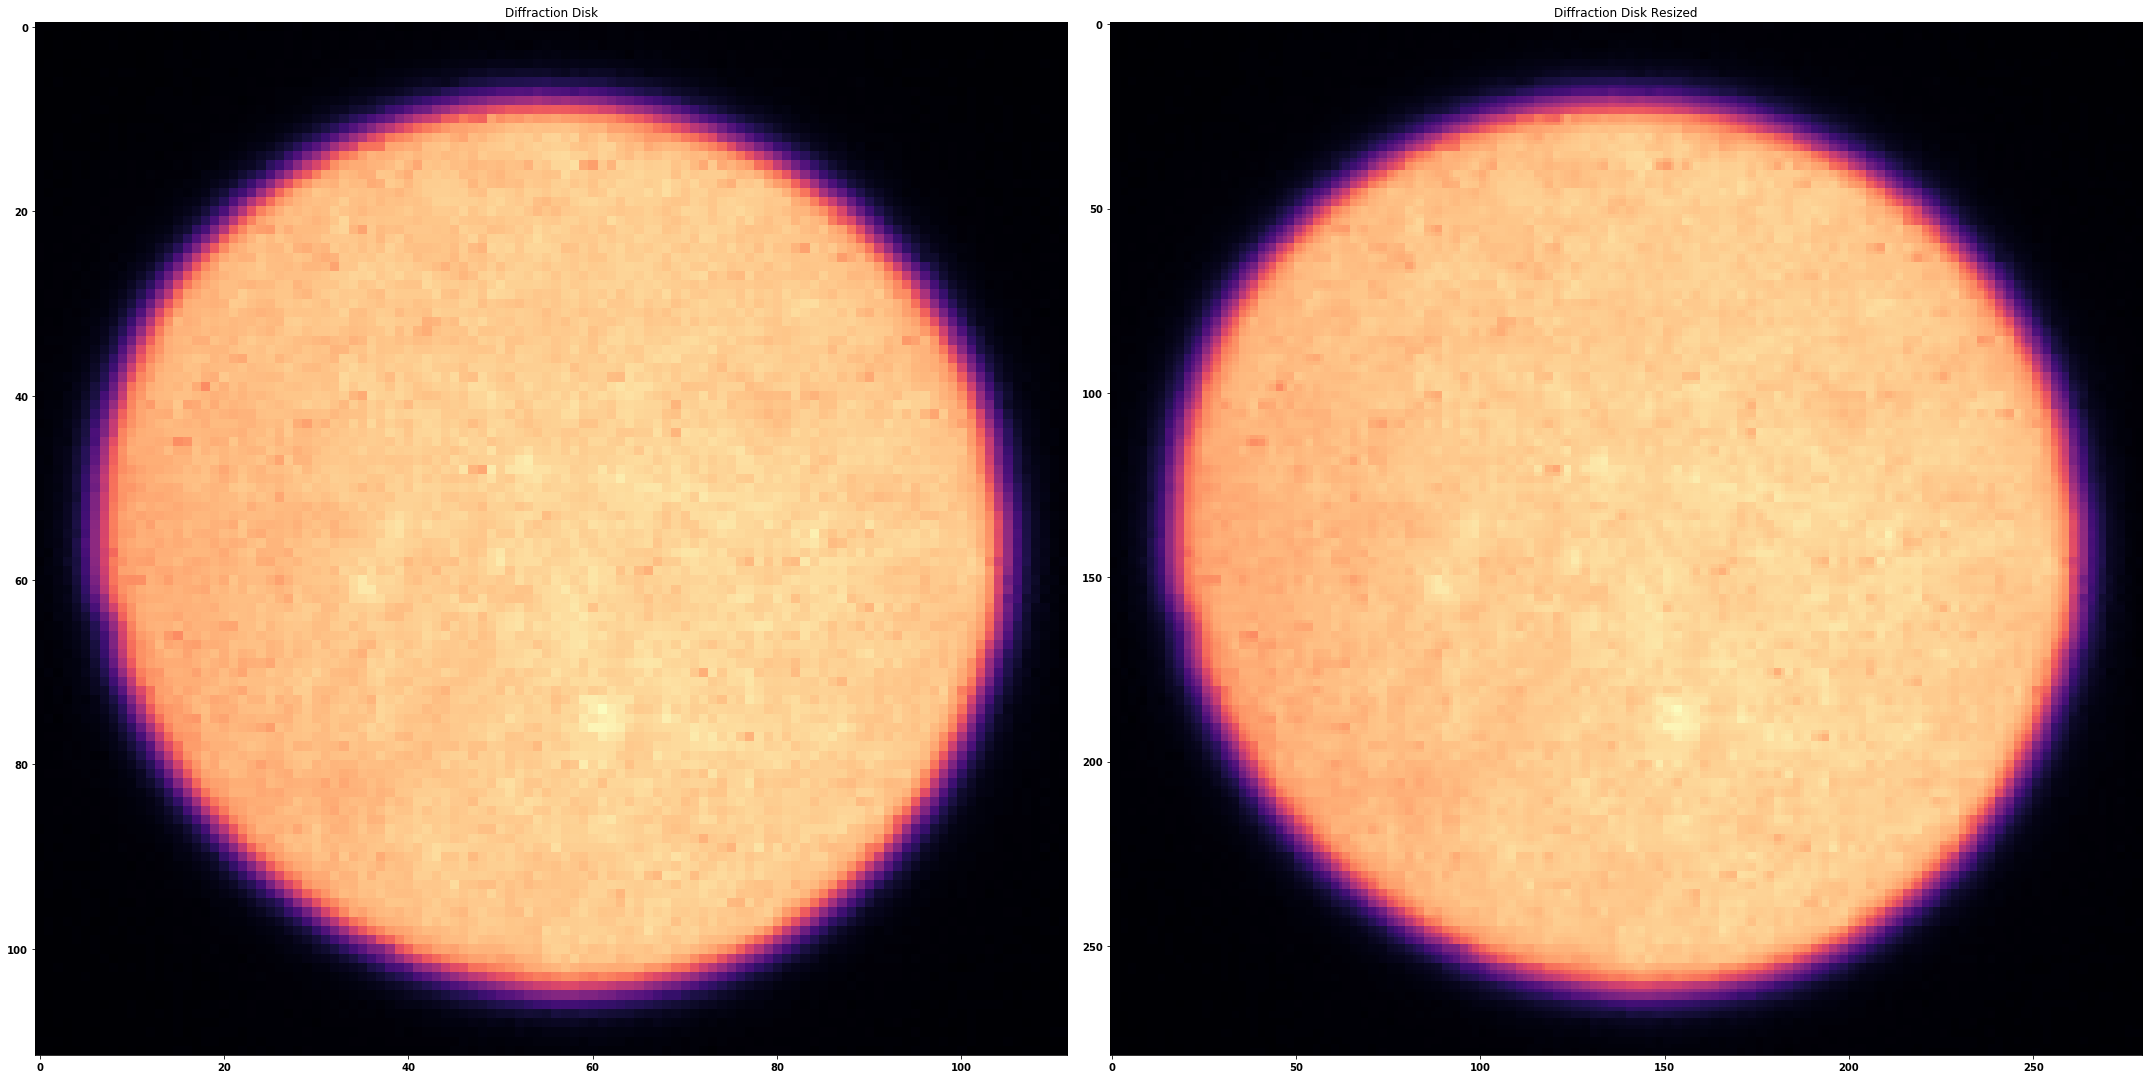

In [21]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(CentralDisk)
plt.title('Diffraction Disk')
plt.subplot(1,2,2)
plt.imshow(resizer2D(CentralDisk,0.4))
plt.title('Diffraction Disk Resized')

In [22]:
calib = infoADF['spatial_calibrations'][0]['scale']
calib_pm = 1000*calib

In [23]:
st.tic()
cbed_sampler = get_sampling(Data_4D.shape,32,60,calib_pm,beam_r)
Flat4DR = resizer4Df(Flat4D,cbed_sampler)
st.toc()

Elapsed time: 18.335896 seconds.



In [24]:
beam_r/cbed_sampler

26.324145232506833

In [25]:
st.tic()
new_radius = beam_r/cbed_sampler
Flat4DP = subpixel_pad4D(Flat4DR,Data_4D.shape[0:2],new_radius)
st.toc()

Elapsed time: 157.894204 seconds.



In [26]:
del Flat4DR

In [27]:
st.tic()
Flat4DP = scnd.rotate(Flat4DP,rotangle,axes=(1,2),reshape=False)
st.toc()

Elapsed time: 475.350109 seconds.



In [28]:
st.tic()
Flat4DP = Flat4DP.astype(np.float32)
st.toc()

Elapsed time: 9.376897 seconds.



In [29]:
st.tic()
new_centraldisk = np.median(Flat4DP,axis=0)
st.toc()

Elapsed time: 192.911147 seconds.



Text(0.5, 1.0, 'Diffraction Disk Resampled & Padded')

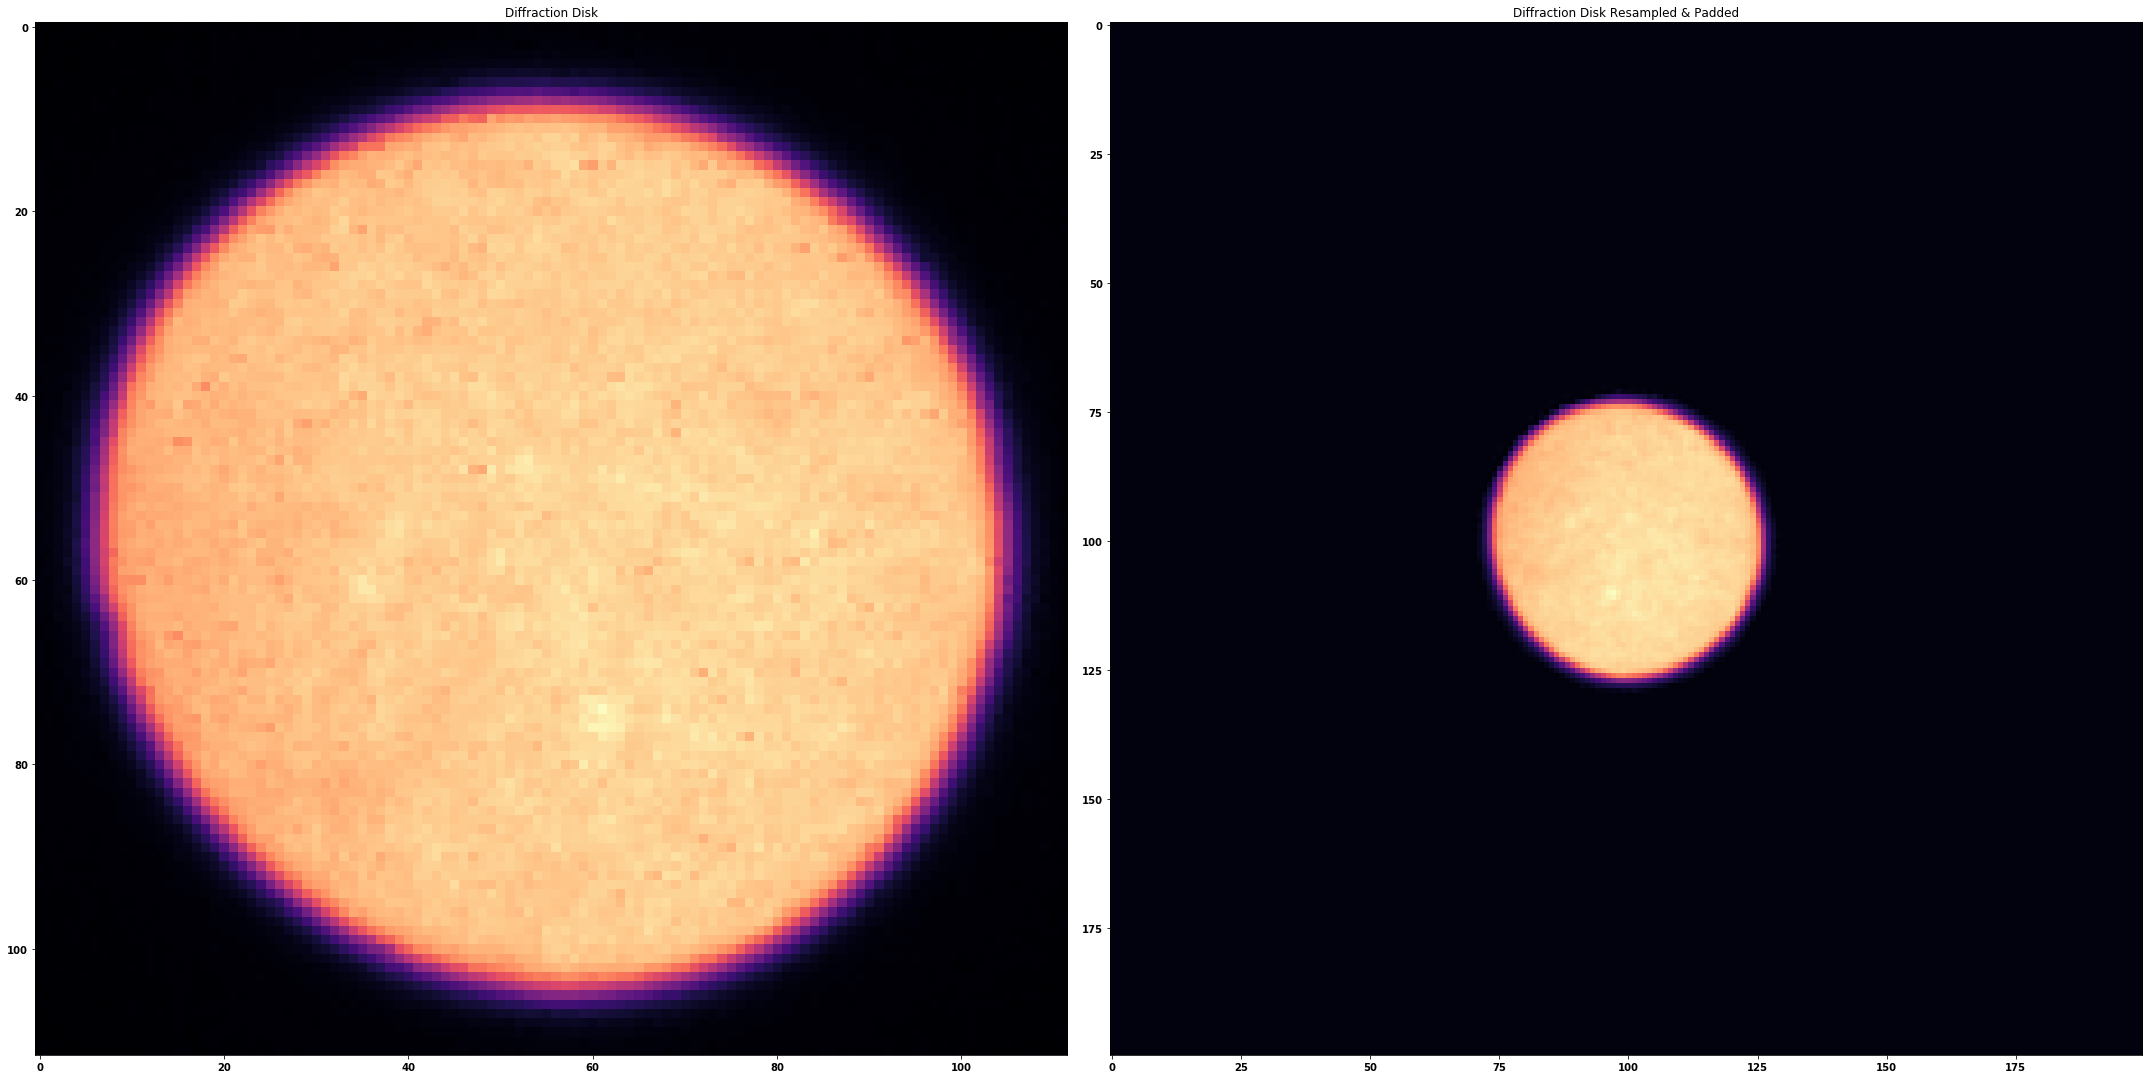

In [30]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(CentralDisk)
plt.title('Diffraction Disk')
plt.subplot(1,2,2)
plt.imshow(new_centraldisk)
plt.title('Diffraction Disk Resampled & Padded')

In [31]:
def get_G_matrix(data4D):
    data4D = np.transpose(data4D,(2,3,0,1)) #real in 2,3 
    data4D = np.fft.fftshift(np.fft.fft2(data4D,axes=(2,3)),axes=(2,3)) #now real is Q' which is 2,3
    return data4D

In [32]:
st.tic()
Processed4D = np.reshape(Flat4DP,(Flat4DP.shape[1],Flat4DP.shape[2],Flat4DP.shape[1],Flat4DP.shape[2]))
Processed4D = get_G_matrix(Processed4D)
st.toc()

Elapsed time: 268.232652 seconds.



In [33]:
@numba.jit
def lobe_calc(data4D,Four_Y,Four_X,FourXY,rsize,cutoff):
    left_image = np.zeros_like(FourXY,dtype=np.complex64)
    rightimage = np.zeros_like(FourXY,dtype=np.complex64)
    d_zero = np.copy(FourXY)
    logical_dzero = d_zero < cutoff
    for pp in range(len(rsize)):
        ii,jj = rsize[pp,:]
        xq = Four_X[ii,jj]
        yq = Four_Y[ii,jj]
        
        cbd = data4D[:,:,ii,jj]
        cbd_phase = np.angle(cbd)
        cbd_ampli = np.abs(cbd)

        d_plus = (((Four_X + xq)**2) + ((Four_Y + yq)**2))**0.5
        d_minu = (((Four_X - xq)**2) + ((Four_Y - yq)**2))**0.5

        ll = np.logical_and((d_plus < cutoff),(d_minu > cutoff))
        ll = np.logical_and(ll,logical_dzero)

        rr = np.logical_and((d_plus > cutoff),(d_minu < cutoff))
        rr = np.logical_and(rr,logical_dzero)
        
        left_trotter = np.multiply(cbd_ampli[ll],np.exp((1j)*cbd_phase[ll]))
        righttrotter = np.multiply(cbd_ampli[rr],np.exp((1j)*cbd_phase[rr]))
        
        left_image[ii,jj] = np.sum(left_trotter)
        rightimage[ii,jj] = np.sum(righttrotter)
    
    return left_image,rightimage
    
def ssb_kernel(processed4D,real_calibration,aperture,voltage):
    data_size = np.asarray(processed4D.shape)
    wavelength = wavelength_pm(voltage)
    cutoff = aperture/(1000*wavelength)
    four_y = np.fft.fftshift(np.fft.fftfreq(data_size[0], real_calibration))
    four_x = np.fft.fftshift(np.fft.fftfreq(data_size[1], real_calibration))
    Four_X,Four_Y = np.meshgrid(four_x,four_y)
    FourXY = np.sqrt((Four_Y ** 2) + (Four_X**2))
    yy,xx = np.mgrid[0:data_size[0],0:data_size[1]]
    rsize = np.zeros((np.size(yy),2),dtype=int)
    rsize[:,0] = np.ravel(yy)
    rsize[:,1] = np.ravel(xx)
    
    #initialize JIT
    left_image,rightimage = lobe_calc(processed4D,Four_Y,Four_X,FourXY,rsize[0:100,:],cutoff)
    
    #pass to JIT kernel
    left_image,rightimage = lobe_calc(processed4D,Four_Y,Four_X,FourXY,rsize,cutoff)
    left_image = np.fft.ifft2(left_image)
    rightimage = np.fft.ifft2(rightimage)
    
    return left_image,rightimage

In [34]:
st.tic()
LSB,RSB = ssb_kernel(Processed4D,calib_pm,32,60)
st.toc()

Elapsed time: 541.864689 seconds.



Text(0.5, 1.0, 'FFT of ADF data')

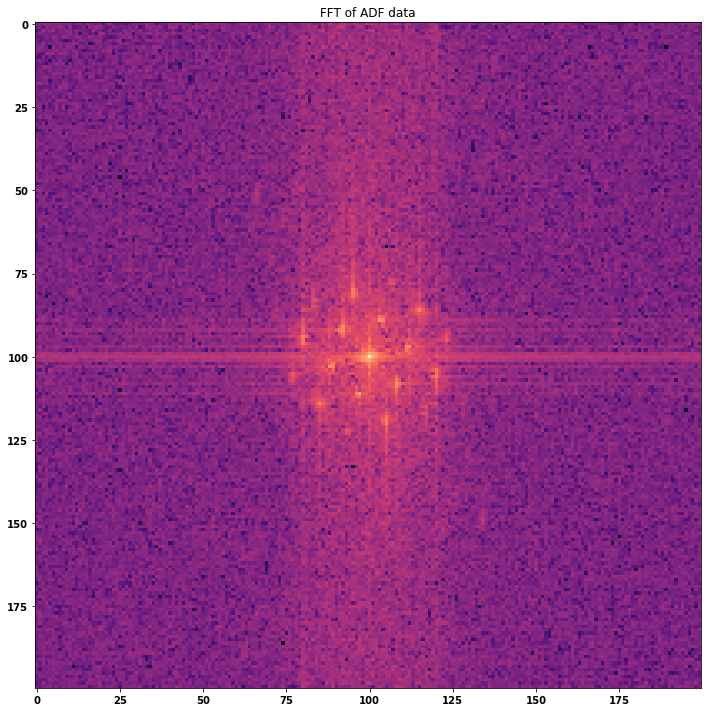

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(DataADF)))))
plt.title('FFT of ADF data')

Text(0.5, 1.0, 'Phase of FFT of data at center')

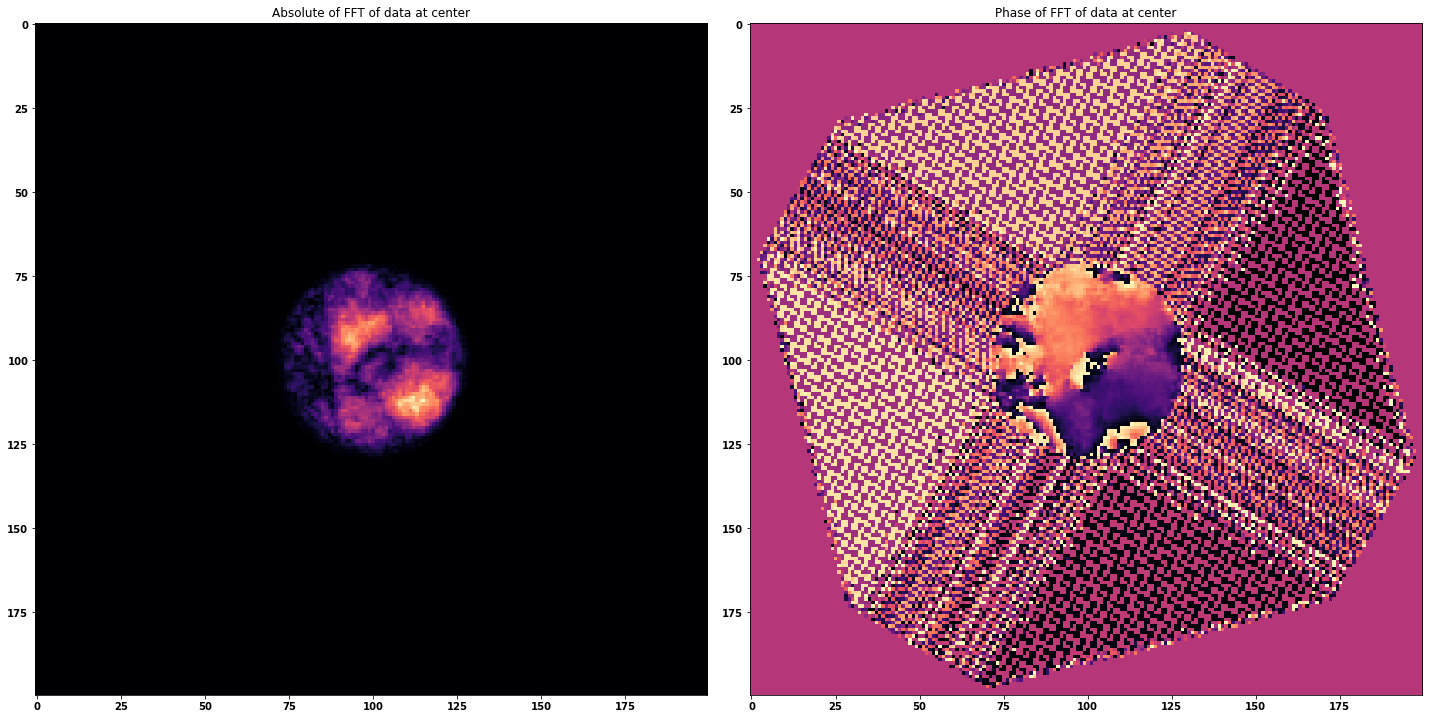

In [36]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(np.abs(Processed4D[:,:,87,120]))
plt.title('Absolute of FFT of data at center')

plt.subplot(1,2,2)
plt.imshow(np.angle(Processed4D[:,:,87,120]))
plt.title('Phase of FFT of data at center')

Text(0.5, 1.0, 'Phase of Right Side Band')

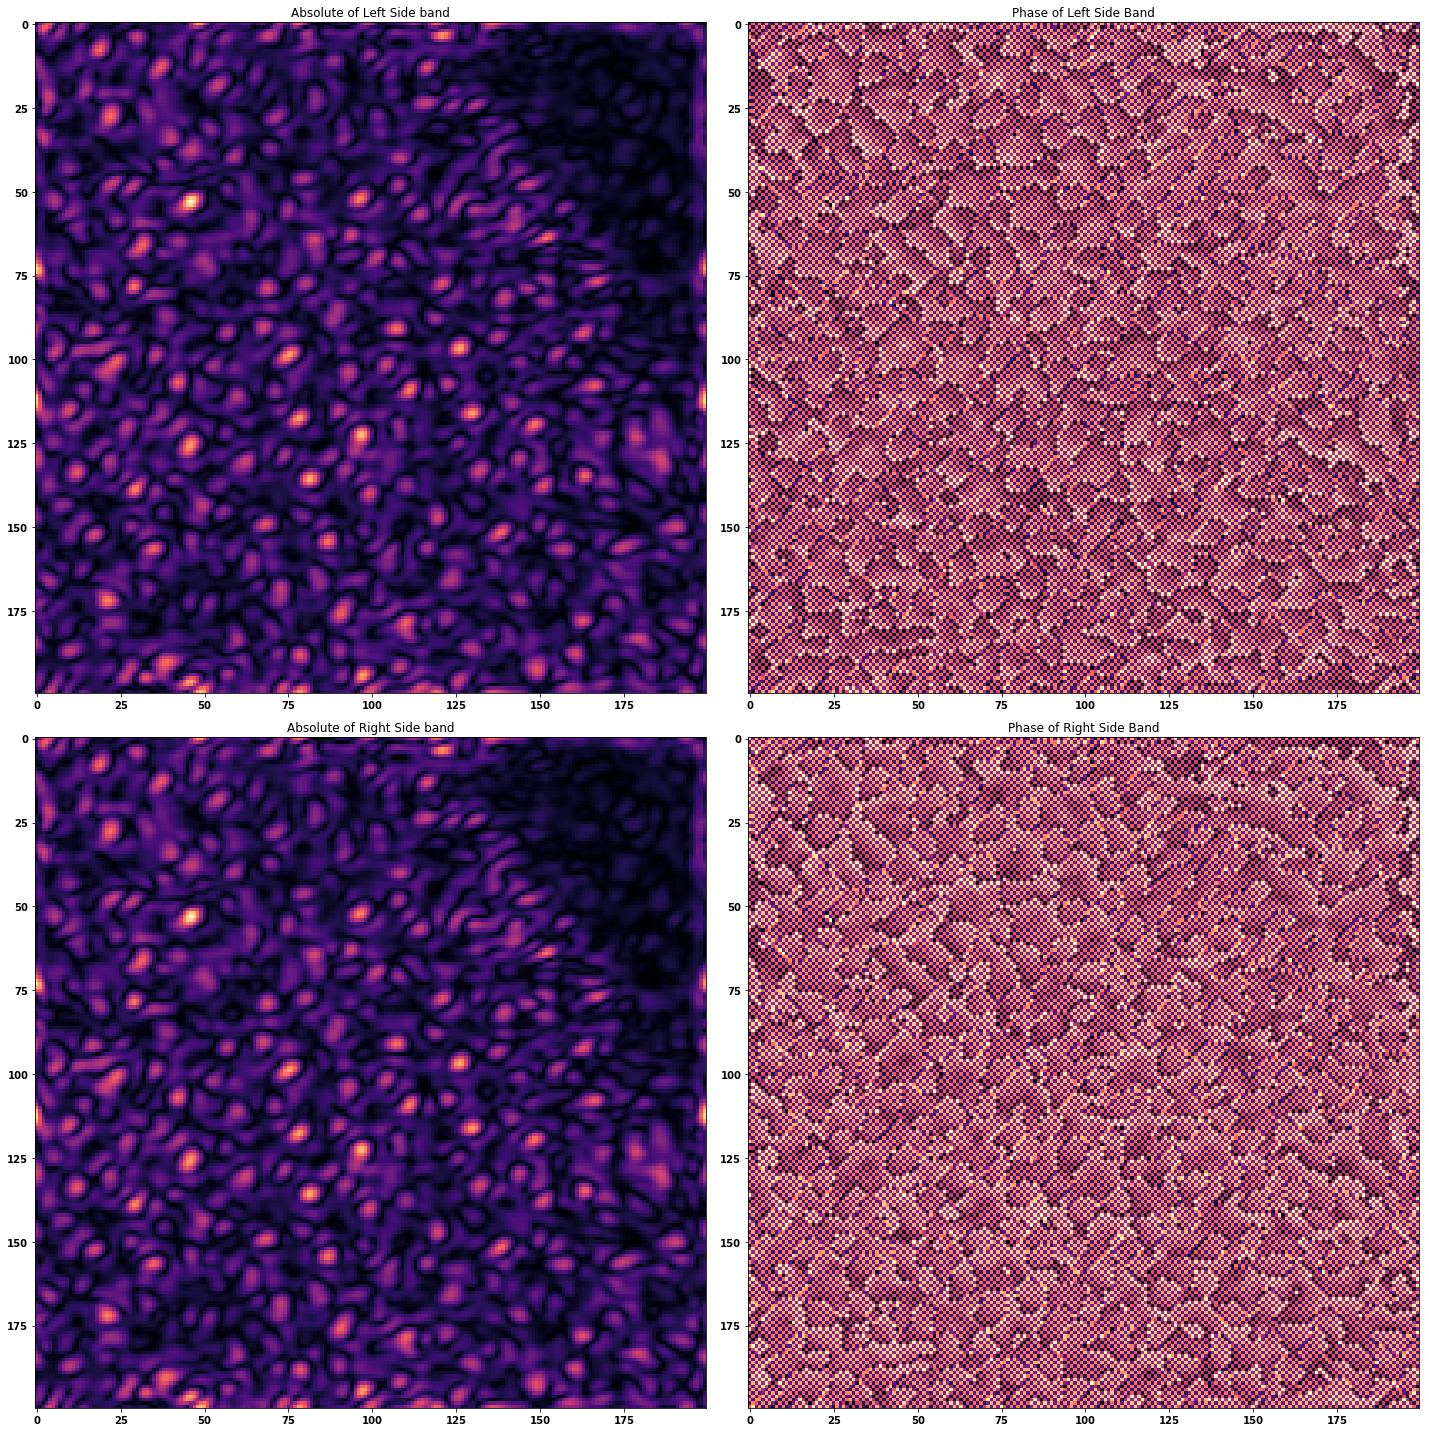

In [37]:
plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(np.abs(LSB))
plt.title('Absolute of Left Side band')

plt.subplot(2,2,2)
plt.imshow(np.angle(LSB))
plt.title('Phase of Left Side Band')

plt.subplot(2,2,3)
plt.imshow(np.abs(RSB))
plt.title('Absolute of Right Side band')

plt.subplot(2,2,4)
plt.imshow(np.angle(RSB))
plt.title('Phase of Right Side Band')